In [1]:
import os,sys
from collections import defaultdict
import json
import numpy as np
import pickle
%load_ext autoreload
%autoreload 2

In [2]:
PATH = '/home/eddyod/programming/pipeline_utility'
MESH_DIR = '/net/birdstore/Active_Atlas_Data/data_root/CSHL_meshes'
sys.path.append(PATH)
from utilities.imported_atlas_utilities import load_original_volume_all_known_structures_v3, get_centroid_3d, \
    load_alignment_results_v3, transform_points, average_location, plot_centroid_means_and_covars_3d, \
    convert_to_original_name, name_unsided_to_color, get_structure_mean_positions_filepath, paired_structures, \
    convert_to_left_name, convert_to_right_name, load_original_volume_v2
from utilities.aligner_v3 import Aligner


Connecting dklab@192.168.1.12:3306


In [27]:
INPUT_KEY_LOC = os.path.join(PATH, 'neuroglancer', 'structure_key_minimal.json')
NUM_STRUCTS = 49
with open(INPUT_KEY_LOC, 'r') as f:
    structures = json.load(f)
structures = list(structures.values())
structures = structures[0:5]

In [28]:
structures

['10N_L', '10N_R', '12N', '3N_L', '3N_R']

In [29]:
atlas_name = 'atlasV7'
fixed_brain_name = 'MD589'
moving_brain_names = ['MD585', 'MD594']
resolution = '10.0um'
resolution_um = 10.0
structure_centroids_all_brains_um_wrt_fixed = []
fixed_brain_spec = {'name': fixed_brain_name, 'vol_type': 'annotationAsScore', 'resolution': resolution}

In [30]:
fixed_brain = load_original_volume_all_known_structures_v3(stack_spec=fixed_brain_spec, structures=structures)
fixed_brain_structure_centroids = get_centroid_3d(fixed_brain)
print('fixed_brain_structure_centroids', fixed_brain_structure_centroids)
fixed_brain_structure_centroids_um = {s: c * resolution_um for s, c in fixed_brain_structure_centroids.items()}
print('fixed_brain_structure_centroids_um', fixed_brain_structure_centroids_um)
structure_centroids_all_brains_um_wrt_fixed.append(fixed_brain_structure_centroids_um)

{'name': 'MD589', 'vol_type': 'annotationAsScore', 'resolution': '10.0um'}
/net/birdstore/Active_Atlas_Data/data_root/CSHL_volumes/MD589/10.0um_annotationAsScoreVolume/10N_L.npy
loaded_cropbox_resolution 10.0um
{'name': 'MD589', 'vol_type': 'annotationAsScore', 'resolution': '10.0um'}
/net/birdstore/Active_Atlas_Data/data_root/CSHL_volumes/MD589/10.0um_annotationAsScoreVolume/10N_R.npy
loaded_cropbox_resolution 10.0um
{'name': 'MD589', 'vol_type': 'annotationAsScore', 'resolution': '10.0um'}
/net/birdstore/Active_Atlas_Data/data_root/CSHL_volumes/MD589/10.0um_annotationAsScoreVolume/12N.npy
loaded_cropbox_resolution 10.0um
{'name': 'MD589', 'vol_type': 'annotationAsScore', 'resolution': '10.0um'}
/net/birdstore/Active_Atlas_Data/data_root/CSHL_volumes/MD589/10.0um_annotationAsScoreVolume/3N_L.npy
loaded_cropbox_resolution 10.0um
{'name': 'MD589', 'vol_type': 'annotationAsScore', 'resolution': '10.0um'}
/net/birdstore/Active_Atlas_Data/data_root/CSHL_volumes/MD589/10.0um_annotationAsSco

Prior structure/index map not found. Generating a new one.


## Compute instance centroids

In [22]:
for brain_m in moving_brain_names:
    moving_brain_spec = {'name': brain_m, 'vol_type': 'annotationAsScore', 'resolution': resolution}
    print('Brain', moving_brain_spec)
    moving_brain = load_original_volume_all_known_structures_v3(stack_spec=moving_brain_spec, structures=structures)
    alignment_spec = dict(stack_m=moving_brain_spec, stack_f=fixed_brain_spec, warp_setting=109)
    moving_brain_structure_centroids_input_resol = get_centroid_3d(moving_brain)
    # Load registration.
    # Alignment results fp: os.path.join(reg_root_dir, alignment_spec['stack_m']['name'], warp_basename, warp_basename + '_' + what + '.' + ext)
    transform_parameters_moving_brain_to_fixed_brain = load_alignment_results_v3(alignment_spec=alignment_spec, what='parameters')
    # Transform moving brains into alignment with the fixed brain.
    transformed_moving_brain_structure_centroids_input_resol_wrt_fixed = \
        dict(zip(moving_brain_structure_centroids_input_resol.keys(),
                 transform_points(pts=moving_brain_structure_centroids_input_resol.values(),
                                  transform=transform_parameters_moving_brain_to_fixed_brain)))

    transformed_moving_brain_structure_centroids_um_wrt_fixed = \
        {s: c * resolution_um for s, c in
         transformed_moving_brain_structure_centroids_input_resol_wrt_fixed.items()}

    structure_centroids_all_brains_um_wrt_fixed.append(transformed_moving_brain_structure_centroids_um_wrt_fixed)


Brain {'name': 'MD585', 'vol_type': 'annotationAsScore', 'resolution': '10.0um'}
{'name': 'MD585', 'vol_type': 'annotationAsScore', 'resolution': '10.0um'}
/net/birdstore/Active_Atlas_Data/data_root/CSHL_volumes/MD585/10.0um_annotationAsScoreVolume/12N.npy
loaded_cropbox_resolution 10.0um
get_alignment_result_filepath_v3 /net/birdstore/Active_Atlas_Data/data_root/CSHL_registration_parameters/MD585/MD585_10.0um_annotationAsScoreVolume_warp109_MD589_10.0um_annotationAsScoreVolume/parameters.json
Brain {'name': 'MD594', 'vol_type': 'annotationAsScore', 'resolution': '10.0um'}
{'name': 'MD594', 'vol_type': 'annotationAsScore', 'resolution': '10.0um'}
/net/birdstore/Active_Atlas_Data/data_root/CSHL_volumes/MD594/10.0um_annotationAsScoreVolume/12N.npy
loaded_cropbox_resolution 10.0um
get_alignment_result_filepath_v3 /net/birdstore/Active_Atlas_Data/data_root/CSHL_registration_parameters/MD594/MD594_10.0um_annotationAsScoreVolume_warp109_MD589_10.0um_annotationAsScoreVolume/parameters.json


Prior structure/index map not found. Generating a new one.
Prior structure/index map not found. Generating a new one.


In [23]:
structure_centroids_all_brains_um_grouped_by_structure_wrt_fixed = defaultdict(list)
for sc in structure_centroids_all_brains_um_wrt_fixed:
    for k, c in sc.items():
        structure_centroids_all_brains_um_grouped_by_structure_wrt_fixed[k].append(c)
structure_centroids_all_brains_um_grouped_by_structure_wrt_fixed.default_factory = None

## Compute standard centroids

In [24]:
nominal_centroids_wrt_canonicalAtlasSpace_um, \
instance_centroids_wrt_canonicalAtlasSpace_um, \
canonical_center_wrt_fixed_um, \
canonical_normal, \
transform_matrix_to_canonicalAtlasSpace_um = \
average_location(structure_centroids_all_brains_um_grouped_by_structure_wrt_fixed)

Mid-sagittal plane normal vector = [0. 0. 1.] @ Mid-sagittal plane anchor wrt fixed wholebrain = [15056.11829796  7783.96053549  6081.95439846]
Transform matrix to canonical atlas space =
[[ 1.00000000e+00  0.00000000e+00  0.00000000e+00 -1.50561183e+04]
 [ 0.00000000e+00  1.00000000e+00  0.00000000e+00 -7.78396054e+03]
 [ 0.00000000e+00  0.00000000e+00  1.00000000e+00 -6.08195440e+03]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]
Angular deviation of the mid sagittal plane normal around y axis (degree) = 0.0


In [25]:
colors = {name_s: np.array(name_unsided_to_color[convert_to_original_name(name_s)])/255.
                                        for name_s in instance_centroids_wrt_canonicalAtlasSpace_um.keys()}

No handles with labels found to put in legend.


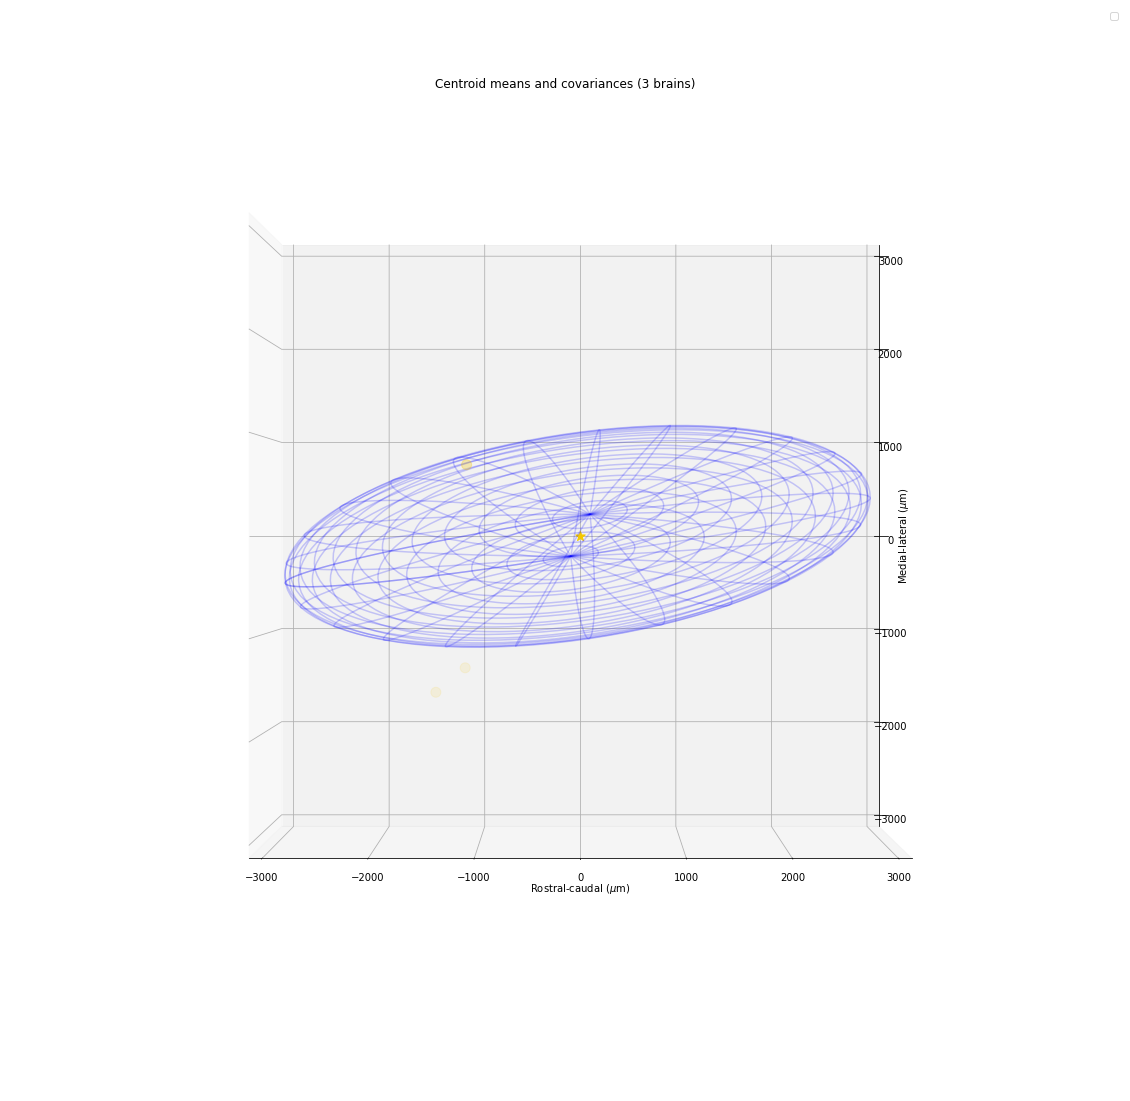

In [26]:
plot_centroid_means_and_covars_3d(instance_centroids=instance_centroids_wrt_canonicalAtlasSpace_um,
                                 nominal_locations=nominal_centroids_wrt_canonicalAtlasSpace_um,
                                 canonical_centroid=(0,0,0),
                                  show_canonical_centroid=False,
                                  canonical_normal=[0,0,1],
                                 colors=colors,
                                 xlim=[-3000, 3000],
                                 ylim=[-3000, 3000],
                                 zlim=[-3000, 3000],
                                 xlabel='Rostral-caudal ($\mu$m)',
                                 ylabel='',
                                 zlabel='Medial-lateral ($\mu$m)',
                                 title='Centroid means and covariances (3 brains)')

In [ ]:
filepath = os.path.join(MESH_DIR, 'atlasV7', '1um_meanPositions.pkl')
with open(filepath, 'wb') as f:
    pickle.dump(nominal_centroids_wrt_canonicalAtlasSpace_um, f)

In [ ]:
filepath = os.path.join(MESH_DIR, 'atlasV7', 'canonicalCentroid_wrt_fixedWholebrain.txt')
np.savetxt(filepath, canonical_center_wrt_fixed_um)

In [ ]:
reg_root_dir=os.path.join(MESH_ROOTDIR, atlas_name, 'mean_shapes', 'instance_registration')


In [ ]:
# Note that all shapes have voxel resolution matching input resolution (10.0 micron).
for name_u in ['12N']:
#for name_u in all_known_structures:
    # Load instance volumes.
    instance_volumes = []
    instance_source = []
    
    if name_u in paired_structures:
        left_name = convert_to_left_name(name_u)
        right_name = convert_to_right_name(name_u)
    else:
        left_name = name_u
        right_name = name_u
            
    for brain_name in [fixed_brain_name] + moving_brain_names:
        brain_spec = {'name': brain_name, 'vol_type': 'annotationAsScore', 'resolution': resolution}
        right_instance_vol, _ = load_original_volume_v2(stack_spec=brain_spec, 
                                                                 structure=right_name, 
                                                                return_origin_instead_of_bbox=True,
                                                                crop_to_minimal=True)
        instance_volumes.append(right_instance_vol) # if right, do not mirror
        instance_source.append((brain_name, 'R'))

        left_instance_vol, _ = load_original_volume_v2(stack_spec=brain_spec, 
                                                                 structure=left_name, 
                                                                return_origin_instead_of_bbox=True,
                                                                crop_to_minimal=True)
        instance_volumes.append(left_instance_vol[..., ::-1]) # if left, mirror
        instance_source.append((brain_name, 'L'))
            
   # Use the first instance as registration target.
    # Register every other instance to the first instance.
    template_instance_volume = instance_volumes[0]    
    template_instance_centroid_wrt_templateOrigin = get_centroid_3d(template_instance_volume).astype(np.int16)
    template_instance_wrt_templateCentroid = (template_instance_volume, - template_instance_centroid_wrt_templateOrigin)
    aligned_moving_instance_wrt_templateCentroid_all_instances = []

    for i in range(1, len(instance_volumes)):
        print('Registering {} instance {} to instance 0'.format(name_u, i))
        # Compute transform.
        moving_instance_volume = instance_volumes[i]
        aligner = Aligner({0: template_instance_wrt_templateCentroid}, 
                          {0: (moving_instance_volume, np.array((0,0,0)))}, 
                          labelIndexMap_m2f={0:0},
                         verbose=False)
        aligner.set_centroid(centroid_m='structure_centroid', centroid_f='structure_centroid')
        aligner.compute_gradient(smooth_first=True)
        lr = 1.
        _, _ = aligner.optimize(tf_type='rigid', 
                             history_len=100, 
                            max_iter_num=100 if name_u in ['SC', 'IC'] else 1000,
                             grad_computation_sample_number=None,
                                full_lr=np.array([lr,lr,lr,0.1,0.1,0.1]),
                                terminate_thresh_trans=.01
                               )
        
#         plt.figure();
#         plt.plot(aligner.scores);
#         plt.show();        
        # Transform instances.
        T = convert_transform_forms(aligner=aligner, out_form=(3,4), select_best='max_value')
        aligned_moving_instance_volume, aligned_moving_instance_origin_wrt_templateCentroid = \
        transform_volume_v4(volume=(moving_instance_volume, (0,0,0)), transform=T,
                            return_origin_instead_of_bbox=True)
        aligned_moving_instance_wrt_templateCentroid = (aligned_moving_instance_volume, aligned_moving_instance_origin_wrt_templateCentroid)        
        aligned_moving_instance_wrt_templateCentroid_all_instances.append(aligned_moving_instance_wrt_templateCentroid)

    # Generate meshes for each instance.
    instance_mesh_wrt_templateCentroid_all_instances = [
        volume_to_polydata(v, origin=o, num_simplify_iter=3, smooth=True)
        for v, o in 
        [template_instance_wrt_templateCentroid] + aligned_moving_instance_wrt_templateCentroid_all_instances]
            save_alignment_results_v3(aligner=aligner, 
                                              select_best='max_value',
                          alignment_spec=dict(warp_setting=108, 
                                              stack_f=dict(name='%s_instance0' % name_u, vol_type='annotationAsScore'),
                                             stack_m=dict(name='%s_instance%d' % (name_u, i), vol_type='annotationAsScore')),
                                     reg_root_dir=os.path.join(MESH_ROOTDIR, atlas_name, 'mean_shapes', 'instance_registration'))        
        

#     launch_vtk([actor_mesh(mesh, wireframe=True, color=np.array(high_contrast_colors[i+1])/255., opacity=1, wireframe_linewidth=3) 
#         for i, mesh in enumerate(instance_mesh_wrt_templateCentroid_all_instances)], 
#       background_color=(1,1,1))

    # Save meshes.
    
    for i, m in enumerate(instance_mesh_wrt_templateCentroid_all_instances):
        save_data(m, get_instance_mesh_filepath(atlas_name=atlas_name, structure=name_u, 
                                                    resolution='10um', index=i))
        
    save_data(instance_source, get_instance_sources_filepath(atlas_name=atlas_name, structure=name_u))

    # Compute average shape.
    if name_u == 'IC' or name_u == 'SC':
        # IC and SC boundaries are particularly jagged, so do a larger value smoothing.
        sigma = 5.
    else:
        sigma = 2.

    mean_shape_wrt_templateCentroid = \
        average_shape(volume_origin_list=[template_instance_wrt_templateCentroid] + \
                      aligned_moving_instance_wrt_templateCentroid_all_instances,
                      force_symmetric=(name_u in singular_structures), 
                      sigma=sigma,
                     )
        
    for surface_level in np.arange(0.1, 1.1, .1):
        print("level =", surface_level, ', volume =', 
        np.count_nonzero(mean_shape_wrt_templateCentroid[0] > surface_level) *  resolution_um ** 3 / 1e9, "mm^3")
        
    # Generate meshes for mean shape.
        
    mean_shape_isosurface_polydata_all_levels = \
    {surface_level:         
        volume_to_polydata(mean_shape_wrt_templateCentroid[0] >= surface_level, 
                           origin=mean_shape_wrt_templateCentroid[1], 
                             num_simplify_iter=3, smooth=True, 
                             return_mesh=False)
    for surface_level in np.arange(0.1, 1.1, .1)}
            
    # Identify the surrouding area as additional structure.
    
    wall_level = .5
    surround_distance_um = 200.
        
    surround_wrt_stdShapeCentroid = \
    get_surround_volume_v2(vol=mean_shape_wrt_templateCentroid[0], 
                           origin=mean_shape_wrt_templateCentroid[1],
                           wall_level=wall_level, 
                           distance=surround_distance_um / resolution_um, 
                           prob=True, 
                           return_origin_instead_of_bbox=True, 
                           padding=5)

    # Generate meshes for surrouding area.
        
    surround_isosurface_polydata_all_levels = \
    {surface_level:         
        volume_to_polydata(surround_wrt_stdShapeCentroid[0] >= surface_level, 
                           origin=surround_wrt_stdShapeCentroid[1], 
                             num_simplify_iter=3, smooth=True, 
                             return_mesh=False)
    for surface_level in np.arange(0.1, 1.1, .1)}
    
    
    # Save mean shape.

    save_data(mean_shape_wrt_templateCentroid[0], 
                   get_mean_shape_filepath(atlas_name=atlas_name, structure=name_u, 
                                                       what='volume', resolution=resolution))

    save_data(mean_shape_wrt_templateCentroid[1], 
                   get_mean_shape_filepath(atlas_name=atlas_name, structure=name_u, 
                                                       what='origin_wrt_meanShapeCentroid', resolution=resolution))

    for level in np.arange(0.1, 1.1, .1):
        save_data(mean_shape_isosurface_polydata_all_levels[level], 
                       get_mean_shape_filepath(atlas_name=atlas_name, structure=name_u, 
                                                           what='mesh', resolution=resolution, level=level))

    surround_name = convert_to_surround_name(name_u, margin=str(int(surround_distance_um))+'um')

    save_data(surround_wrt_stdShapeCentroid[0], 
                   get_mean_shape_filepath(atlas_name=atlas_name, structure=surround_name, 
                                                       what='volume', resolution=resolution))

    save_data(surround_wrt_stdShapeCentroid[1], 
                   get_mean_shape_filepath(atlas_name=atlas_name, structure=surround_name, 
                                                       what='origin_wrt_meanShapeCentroid', resolution=resolution))

    for level in np.arange(0.1, 1.1, .1):
        save_data(surround_isosurface_polydata_all_levels[level], 
                       get_mean_shape_filepath(atlas_name=atlas_name, structure=surround_name, 
                                                           what='mesh', resolution=resolution, level=level)) 

In [ ]:
i = 1

print 'Registering %s instance %d to instance 0' % (name_u, i)

# Compute transform.

moving_instance_volume = instance_volumes[i]

aligner = Aligner({0: template_instance_wrt_templateCentroid}, 
                  {0: (moving_instance_volume, np.array((0,0,0)))}, 
                  labelIndexMap_m2f={0:0})
aligner.set_centroid(centroid_m='structure_centroid', centroid_f='structure_centroid')
aligner.compute_gradient(smooth_first=True)

lr = .1
_, _ = aligner.optimize(tf_type='rigid', 
                     history_len=100, 
                    max_iter_num=100 if name_u in ['SC', 'IC'] else 10000,
                     grad_computation_sample_number=None,
                        full_lr=np.array([lr,lr,lr,0.1,0.1,0.1]),
                       terminate_thresh_trans=.01

In [ ]:
plt.plot(aligner.Ts);

In [ ]:
plt.plot(aligner.scores);

In [ ]:
[[  9.69838248e-01   7.41253856e-02   2.32205080e-01  -3.58975061e+01]
 [ -7.00849620e-02   9.97212129e-01  -2.56138103e-02  -3.87932318e+01]
 [ -2.33456356e-01   8.56716872e-03   9.72329540e-01  -1.27806610e+01]]

In [ ]:
# Transform instances.

T = convert_transform_forms(aligner=aligner, out_form=(3,4), select_best='max_value')
print T

aligned_moving_instance_volume, aligned_moving_instance_origin_wrt_templateCentroid = \
transform_volume_v3(moving_instance_volume, origin=(0,0,0), transform_parameters=T,
                    return_origin_instead_of_bbox=True)

aligned_moving_instance_wrt_templateCentroid = (aligned_moving_instance_volume, aligned_moving_instance_origin_wrt_templateCentroid)        

# Generate meshes for each instance.

instance_mesh_wrt_templateCentroid_all_instances = [
volume_to_polydata(v, origin=o, num_simplify_iter=3, smooth=True)
for v, o in 
[template_instance_wrt_templateCentroid] + [aligned_moving_instance_wrt_templateCentroid]]

launch_vtk([actor_mesh(mesh, wireframe=True, color=np.array(high_contrast_colors[i+1])/255., opacity=1) 
    for i, mesh in enumerate([instance_mesh_wrt_templateCentroid_all_instances[0],
                             instance_mesh_wrt_templateCentroid_all_instances[1]])], 
  background_color=(1,1,1))

# Visualize Results

In [ ]:
# for name_u in all_known_structures:
for name_u in ['5N']:
    fig, axes = plt.subplots(1, 5,squeeze=True, figsize=(20,2));
    for i in range(1, 6):
#         try:
        scores = DataManager.load_alignment_results_v3( what='scoreHistory',
      alignment_spec=dict(warp_setting=108, 
                          stack_f=dict(name='%s_instance0' % name_u, vol_type='annotationAsScore'),
                         stack_m=dict(name='%s_instance%d' % (name_u, i), vol_type='annotationAsScore')),
                 reg_root_dir=os.path.join(MESH_ROOTDIR, atlas_name, 'mean_shapes', 'instance_registration'))        
        axes[i-1].plot(scores);
        axes[i-1].set_title('%s_instance%d' % (name_u, i))
#         except:
#             pass
    plt.show();

In [ ]:
# for name_u in all_known_structures:
for name_u in ['5N']:
    fig, axes = plt.subplots(1, 5,squeeze=True, figsize=(20,2));
    for i in range(1, 6):
        try:
            trajectory = DataManager.load_alignment_results_v3(what='trajectory',
                              alignment_spec=dict(warp_setting=108, 
                                                  stack_f=dict(name='%s_instance0' % name_u, vol_type='annotationAsScore'),
                                                 stack_m=dict(name='%s_instance%d' % (name_u, i), vol_type='annotationAsScore')),
                                         reg_root_dir=os.path.join(MESH_ROOTDIR, atlas_name, 'mean_shapes', 'instance_registration'))        
            axes[i-1].plot(trajectory);
            axes[i-1].set_title('%s_instance%d' % (name_u, i))
        except:
            pass
    plt.show();

In [ ]:
for name_u in all_known_structures:

    # Load instance meshes.
    
    instance_meshes = []
    for i in range(6):
        m = load_data(DataManager.get_instance_mesh_filepath(atlas_name=atlas_name, structure=name_u, 
                                                         index=i, resolution='10um'))
        if m is not None:
            instance_meshes.append(m)

    launch_vtk([actor_mesh(m, wireframe=True, 
                           color=np.array(high_contrast_colors[i+1])/255., 
                           opacity=1, wireframe_linewidth=3) 
        for i, m in enumerate(instance_meshes)], 
      background_color=(1,1,1))
    
    # Load average shape.
    
    vol = load_data(DataManager.get_mean_shape_filepath(atlas_name=atlas_name, structure=name_u, what='volume', resolution='10.0um'))
    ori_wrt_meanShapeCentroid = load_data(DataManager.get_mean_shape_filepath(atlas_name=atlas_name, structure=name_u, what='origin_wrt_meanShapeCentroid', resolution='10.0um'))
    
    standard_shape_volume_actor = actor_volume(vol.astype(np.float32), 
                                               what='probability', 
                                               origin=ori_wrt_meanShapeCentroid, 
                                              c=(0,0,0))
    
    launch_vtk([standard_shape_volume_actor])

# Combine standard shapes with standard centroid locations

In [ ]:
atlas_resolution = '10.0um'
atlas_resolution_um = convert_resolution_string_to_um(atlas_resolution)

In [ ]:
nominal_centroids_wrt_canonicalAtlasSpace_um = load_data(DataManager.get_structure_mean_positions_filepath(atlas_name=atlas_name, resolution='1um'))
nominal_centroids_wrt_canonicalAtlasSpace_10um = {s: c / atlas_resolution_um for s, c in nominal_centroids_wrt_canonicalAtlasSpace_um.iteritems()}

mean_shapes_10um_wrt_stdShapeCentroid = {name_u: DataManager.load_mean_shape(atlas_name=atlas_name, structure=name_u, resolution=atlas_resolution) 
                    for name_u in all_known_structures_unsided_including_surround_200um}

In [ ]:
atlas_spec = dict(name='atlasV6', vol_type='score', resolution=atlas_resolution)

In [ ]:
## TODO: simplify this.

# mean_shape_wrt_canonicalAtlasSpace_all_structures_10um = {}

for name_u in all_known_structures:
# for name_u in ['7N']:
      
#     mean_shape_10um, mean_shape_origin_wrt_stdShapeCentroid_10um = mean_shapes_10um_wrt_stdShapeCentroid[name_u]
#     mean_shape_surround_10um, mean_shape_surround_origin_wrt_stdShapeCentroid_10um = mean_shapes_10um_wrt_stdShapeCentroid[convert_to_surround_name(name_u, margin='200um')]
    
    if name_u in singular_structures:
                
        for name in [name_u, convert_to_surround_name(name_u, margin='200um')]:
            
            mean_shape_wrt_canonicalAtlasSpace_10um = (mean_shapes_10um_wrt_stdShapeCentroid[name][0], 
                        mean_shapes_10um_wrt_stdShapeCentroid[name][1] + nominal_centroids_wrt_canonicalAtlasSpace_10um[name_u])
            
#             mean_shape_wrt_canonicalAtlasSpace_all_structures_10um[name] = mean_shape_wrt_canonicalAtlasSpace_10um

            DataManager.save_original_volume(volume=mean_shape_wrt_canonicalAtlasSpace_10um, 
                                             stack_spec=atlas_spec, 
                                             structure=name, wrt='canonicalAtlasSpace')
        
    else:
        
        left_name = convert_to_left_name(name_u)
        left_surround_name = convert_to_surround_name(left_name, margin='200um')
        right_name = convert_to_right_name(name_u)
        right_surround_name = convert_to_surround_name(right_name, margin='200um')

        left_mean_shape_wrt_canonicalAtlasSpace_10um = mirror_volume_v2(volume=mean_shapes_10um_wrt_stdShapeCentroid[name_u],
             centroid_wrt_origin=-mean_shapes_10um_wrt_stdShapeCentroid[name_u][1],
            new_centroid=nominal_centroids_wrt_canonicalAtlasSpace_10um[left_name])

        DataManager.save_original_volume(volume=left_mean_shape_wrt_canonicalAtlasSpace_10um, 
                             stack_spec=atlas_spec, 
                             structure=left_name, wrt='canonicalAtlasSpace')

        left_mean_shape_wrt_canonicalAtlasSpace_10um = mirror_volume_v2(\
            volume=mean_shapes_10um_wrt_stdShapeCentroid[convert_to_surround_name(name_u, margin='200um')][0],
            centroid_wrt_origin=-mean_shapes_10um_wrt_stdShapeCentroid[convert_to_surround_name(name_u, margin='200um')][1],
            new_centroid=nominal_centroids_wrt_canonicalAtlasSpace_10um[left_name])        
        
        DataManager.save_original_volume(volume=left_mean_shape_wrt_canonicalAtlasSpace_10um, 
                             stack_spec=atlas_spec, 
                             structure=left_surround_name, wrt='canonicalAtlasSpace')
        
        
        right_mean_shape_wrt_canonicalAtlasSpace_10um = (mean_shapes_10um_wrt_stdShapeCentroid[name_u][0], 
        mean_shapes_10um_wrt_stdShapeCentroid[name_u][1] + nominal_centroids_wrt_canonicalAtlasSpace_10um[right_name])
        
        DataManager.save_original_volume(volume=right_mean_shape_wrt_canonicalAtlasSpace_10um, 
                                 stack_spec=atlas_spec, 
                                 structure=right_name, wrt='canonicalAtlasSpace')
            
        
        
        right_mean_shape_wrt_canonicalAtlasSpace_10um = (mean_shapes_10um_wrt_stdShapeCentroid[convert_to_surround_name(name_u, margin='200um')][0], 
        mean_shapes_10um_wrt_stdShapeCentroid[convert_to_surround_name(name_u, margin='200um')][1] + nominal_centroids_wrt_canonicalAtlasSpace_10um[right_name])
        
        DataManager.save_original_volume(volume=right_mean_shape_wrt_canonicalAtlasSpace_10um, 
                                 stack_spec=atlas_spec, 
                                 structure=right_surround_name, wrt='canonicalAtlasSpace')

# Convert to vtk polydata for visualization

In [ ]:
for name_s in all_known_structures_sided_including_surround_200um:
# for name_s in ['7N_L', '7N_R']:

    atlas_structure_wrt_canonicalAtlasSpace = \
    DataManager.load_original_volume_v2(stack_spec=atlas_spec, structure=name_s, bbox_wrt='canonicalAtlasSpace')

    for surface_level in np.arange(0.1, 1.1, .1):
        mean_shape_isosurface_polydata_wrt_canonicalAtlasSpace = \
        volume_to_polydata(volume=(atlas_structure_wrt_canonicalAtlasSpace[0] >= surface_level, atlas_structure_wrt_canonicalAtlasSpace[1]), 
                     num_simplify_iter=3, smooth=True, 
                     return_vertex_face_list=False)

        save_data(mean_shape_isosurface_polydata_wrt_canonicalAtlasSpace, 
                  DataManager.get_mesh_filepath_v2(atlas_spec, structure=name_s, level=surface_level))

In [ ]:
mean_shape_level05isosurface_polydata_wrt_canonicalAtlasSpace_all_structures = \
{name_s: load_data(DataManager.get_mesh_filepath_v2(atlas_spec, structure=name_s, level=0.5))
for name_s in all_known_structures_sided}

In [ ]:
launch_vtk([actor_mesh(v, wireframe=False, opacity=.5, color=name_unsided_to_color_float[convert_to_original_name(s)]) 
            for s, v in mean_shape_level05isosurface_polydata_wrt_canonicalAtlasSpace_all_structures.iteritems()] \
          + [actor_sphere([0,0,0])])

# Shell

Just use MD589's shell, until we find a way to average the outlines.

In [ ]:
from conversion import *

margin_um = 200
margin_tb = margin_um / XY_PIXEL_DISTANCE_TB

from scipy.ndimage.morphology import distance_transform_edt

# for stack in ['MD594', 'MD585', 'MD593', 'MD592', 'MD590', 'MD591', 'MD595', 'MD598', 'MD602']:
for stack in ['MD589']:
    
#     contours_valid_by_z = {}
    contour_prob_maps_by_sec = {}
    
    for sec in metadata_cache['valid_sections'][stack]:
                
        m = DataManager.load_thumbnail_mask_v3(stack, prep_id=2, section=sec)
        contours = find_contour_points(m, sample_every=1)[1]
        contours_valid = [cnt[(cnt[:,0] >= 1) & (cnt[:,1] >= 1)] for cnt in contours]
        
#         z = np.mean(DataManager.convert_section_to_z(stack, sec, downsample=32, z_begin=0))
#         contours_valid_by_z[z] = contours_valid[0]
        
        m2 = np.zeros_like(m, np.bool)
        for cnt in contours_valid:
            m2[cnt[:,1], cnt[:,0]] = 1
        distance_to_contour = distance_transform_edt(~m2)
        contour_prob_map = np.exp(-distance_to_contour**2/(2*margin_tb)**2)
        contour_prob_map[contour_prob_map < 1e-2] = 0
        contour_prob_maps_by_sec[sec] = contour_prob_map
        
outline_prob_volume_atlasResol, outline_prob_volume_origin_wrt_wholebrainXYcropped_atlasResol = \
images_to_volume_v2(images=contour_prob_maps_by_sec, spacing_um=20, 
                    in_resol_um=convert_resolution_string_to_um(resolution='down32', stack=stack_fixed),
                    out_resol_um = atlas_resolution_um)
                                                                    
# outline_prob_volume_bbox (xm,xm,ym,ym) relative to cropped, (zm,zm) relative to uncropped.

# crop_box = metadata_cache['cropbox']['MD589']
alignedBrainstemCrop_cropbox_down32 = DataManager.load_cropbox_v2(stack=stack_fixed, prep_id='alignedBrainstemCrop')
alignedBrainstemCrop_cropbox_atlasResol = alignedBrainstemCrop_cropbox_down32 * convert_resolution_string_to_um('down32', stack=stack_fixed) / atlas_resolution_um

outline_prob_volume_origin_rel2fixedwholebrain_atlasResol = outline_prob_volume_origin_wrt_wholebrainXYcropped_atlasResol + (alignedBrainstemCrop_cropbox_atlasResol[0], alignedBrainstemCrop_cropbox_atlasResol[2], 0)

display_volume_sections(outline_prob_volume, direction='z', ncols=5, cmap=plt.cm.gray, start_level=0)

In [ ]:
outline_prob_volume_origin_rel2canon_atlasResol = outline_prob_volume_origin_rel2fixedwholebrain_atlasResol - \
canonical_center_wrt_fixed_um/convert_resolution_string_to_um(resolution='10.0um')

In [ ]:
shell_vol_origin_dict_rel2canon = {'shell': (outline_prob_volume_atlasResol, outline_prob_volume_origin_rel2canon_atlasResol)}

# Side task: compute the volumes of structures

In [ ]:
volumes = \
DataManager.load_original_volume_all_known_structures_v3(atlas_spec, 
                                                         in_bbox_wrt='canonicalAtlasSpace',
                                                         include_surround=True, 
                           structures=all_known_structures_sided)

volumes_mm3 = defaultdict(dict)
for name_u in all_known_structures:
    for level in np.arange(0, 1.1, .1):
        volumes_mm3[name_u][level] = np.count_nonzero(volumes[convert_to_left_name(name_u)][0] > level) * 10.**3 / 1e9

In [ ]:
DataFrame(volumes_mm3).to_csv('/home/yuncong/structure_volumes_mm3.csv')

# Load

In [ ]:
standard_shape_level05surface_polydata_wrt_canonicalAtlasSpace_all_structures = \
DataManager.load_meshes_v2(atlas_spec, levels=.5, include_surround=True, 
                           structures=all_known_structures_sided)
#                            structures=all_known_structures_sided + all_known_structures_sided_with_surround_200um)

In [ ]:
launch_vtk([actor_mesh(p, wireframe=True) 
           for s, p in standard_shape_level05surface_polydata_wrt_canonicalAtlasSpace_all_structures.iteritems()] \
            + [actor_sphere((0,0,0), radius=1)])

In [ ]:
# Show multiple iso-surfaces

standard_shape_level010surface_polydata_wrt_canonicalAtlasSpace_all_structures = \
DataManager.load_meshes_v2(atlas_spec, levels=.1, include_surround=True, 
                           structures=all_known_structures_sided)
#                            structures=all_known_structures_sided + all_known_structures_sided_with_surround_200um)

standard_shape_level090surface_polydata_wrt_canonicalAtlasSpace_all_structures = \
DataManager.load_meshes_v2(atlas_spec, levels=.9, include_surround=True, 
                           structures=all_known_structures_sided)
#                            structures=all_known_structures_sided + all_known_structures_sided_with_surround_200um)

launch_vtk([actor_mesh(p, wireframe=False, color=name_unsided_to_color_float[convert_to_unsided_label(s)], opacity=.2) 
           for s, p in standard_shape_level010surface_polydata_wrt_canonicalAtlasSpace_all_structures.iteritems()] \
           + [actor_mesh(p, wireframe=False, color=name_unsided_to_color_float[convert_to_unsided_label(s)], opacity=.1) 
           for s, p in standard_shape_level090surface_polydata_wrt_canonicalAtlasSpace_all_structures.iteritems()] \
            + [actor_sphere((0,0,0), radius=1)])

In [ ]:
# Load shell

stack_fixed = 'MD589'
shell_polydata_rel2fixedWholebrain = DataManager.load_mesh_v2(brain_spec={'name':stack_fixed, 
                                                                    'vol_type':'annotationAsScore',
                                                                   'resolution':'10.0um'}, 
                                                        structure='shell')

shell_polydata_rel2canonicalAtlasSpace = move_polydata(shell_polydata_rel2fixedWholebrain,
                                                       -canonical_center_wrt_fixed_um / convert_resolution_string_to_um(resolution='10.0um'))

shell_actor_rel2canon = actor_mesh(shell_polydata_rel2fixedWholebrain, (1,1,1), opacity=.15, 
                              wireframe=False, origin=-canonical_center_wrt_fixed_um / convert_resolution_string_to_um(resolution='10.0um'))

In [ ]:
save_data(shell_polydata_rel2canonicalAtlasSpace, 
          DataManager.get_mesh_filepath_v2(atlas_spec, structure='shell', level=None))

In [ ]:
launch_vtk([actor_mesh(p, wireframe=False, color=name_unsided_to_color_float[convert_to_unsided_label(s)], opacity=.2) 
           for s, p in standard_shape_level010surface_polydata_wrt_canonicalAtlasSpace_all_structures.iteritems()] \
           + [actor_mesh(p, wireframe=False, color=name_unsided_to_color_float[convert_to_unsided_label(s)], opacity=.1) 
           for s, p in standard_shape_level090surface_polydata_wrt_canonicalAtlasSpace_all_structures.iteritems()] \
            + [actor_sphere((0,0,0), radius=1)]\
#           +[shell_actor_rel2canon] \
           +[actor_mesh(shell_polydata_rel2canonicalAtlasSpace, (1,1,1), opacity=.15, 
                              wireframe=False)]
#           +[actor_volume(shell_vol_origin_dict_rel2canon['shell'][0].astype(np.float32), 
#                          what='probability', origin=shell_vol_origin_dict_rel2canon['shell'][1])]
          )

In [ ]:
# atlas_volume, structure_to_label, label_to_structure = \
# DataManager.load_original_volume_all_known_structures(stack=atlas_name, sided=True)

In [ ]:
vol, origin_rel2canon = structure_vol_origin_dicts_rel2canon['7N_L']

one_structure_volume_actor_rel2canon = actor_volume(vol.astype(np.float32), what='score', 
                                              origin=origin_rel2canon,
                                                    auxdata=0.8*(vol>0.1).astype(np.float32),
                                              c=np.array(name_unsided_to_color['7N'])/255.)
#                                             c=np.array((1,0,0)))

# Render

In [ ]:
launch_vtk([] \
    + structure_mesh_actors_rel2canon \
#     + [one_structure_volume_actor_rel2canon] \
#     + [shell_volume_actor_rel2canon] \
#     + structure_mesh_surround_actors_rel2canon \
    + [shell_actor_rel2canon] \
    + [actor_sphere((0,0,0), radius=1)], 
           init_angle='sagittal', 
    background_color=(1,1,1),
depth_peeling=True)